In [19]:
'''
Title:       Optimale Steuerung und Regelung:
Subttitle:   3. Aufgabe
Author:      Stefan Kaufmann
MaNr.        51867606
Date:        06.06.2023
'''

'\nTitle:       Optimale Steuerung und Regelung:\nSubttitle:   3. Aufgabe\nAuthor:      Stefan Kaufmann\nMaNr.        51867606\nDate:        06.06.2023\n'

# Optimale Steuerung und Regelung
## 3. Randwertproblem
### Stefan Kaufmann - 51867606

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

import casadi as cas
import libop as libop

# 1. Model    
    
$
\dot{X}(t) = f (x(t),u(t)) = 
\begin{bmatrix}
\omega (t) \\
\frac{mga sin{\Theta (t) -d \omega(t) +mau(t) cos{\Theta (t)}}}{J+ma^{2}} \\
v(t) \\
u(t)
\end{bmatrix}
$

In [21]:
global nx, nu, nxu, N, t, Ta, S, M, Q, R


t_end = 4
N = 50
t = np.linspace(0,t_end,N+1)

# Anzahl an Zuständen und Eingängen
nx = 4
nu = 1
nxu = nx+nu

M = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1]])

Q = np.eye(4)
S = np.diag([0,0,5,0])
R = 0.1


In [22]:
# Parameter
global J,a,m,d,g

J = 0.0361  # kgm²
a = 0.42    # m
m = 0.3553  # kg
d = 0.005   # Nms
g = 9.81    # m/s²

In [23]:
# System dynamic
def System_dynamic(x,u):
    dx = np.zeros(nx)
    dx[0] = x[1]
    dx[1] = (m*g*a*np.sin(x[0])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    dx[2] = x[3]
    dx[3] = u

    return dx

In [24]:
# Ableitungen

def dfdx(x,u):    
    A =np.zeros((nx,nx))
    A[0,1] = (m*g*np.cos(x[0])-m*a*np.sin(x[0])*u)/(J+m*a**2)   
    A[1,1] = -d/(J+m*a**2)                                      
    A[2,3] = 1                                                  
    return A

def dfdu(x,u):    
    B = np.zeros((nx,nu))                                        
    B[1,0] = (m*a*np.cos(x[0]))/(J+m*a**2)                        
    B[3,0] = 1                                                    
    return B

# 2. Zwei-Punkt Randwertproblem Allgemein 

In [25]:
mu = 0.02
l = 0.0279
eta = 0.01
def fun_measles(x, y):
    beta = 1575 * (1 + np.cos(2 * np.pi * x))
    return np.vstack((
        mu - beta * y[0] * y[2],
        beta * y[0] * y[2] - y[1] / l,
        y[1] / l - y[2] / eta
    ))


def bc_measles(ya, yb):
    return ya - yb

x_measles = np.linspace(0, 1, 5)
y_measles = np.full((3, x_measles.shape[0]), 0.01)

res_measles = solve_bvp(fun_measles, bc_measles, x_measles, y_measles, verbose=2)


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.21e-02       5.42e-19           5              4       
       2          1.93e-02       7.05e-19           9              4       
       3          2.67e-02       4.09e-18          13              7       
       4          2.58e-02       1.39e-17          20             12       
       5          3.30e-02       1.39e-17          32             25       
       6          1.93e-04       0.00e+00          57              0       
Solved in 6 iterations, number of nodes 57. 
Maximum relative residual: 1.93e-04 
Maximum boundary residual: 0.00e+00


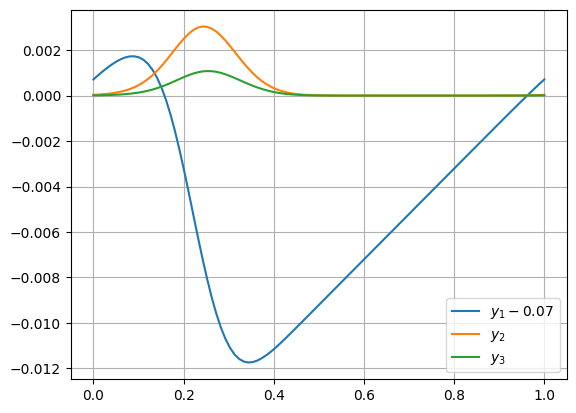

In [26]:
x_measles_plot = np.linspace(0, 1, 100)
y_measles_plot = res_measles.sol(x_measles_plot)



plt.plot(x_measles_plot, y_measles_plot[0] - 0.07, label='$y_1 - 0.07$')
plt.plot(x_measles_plot, y_measles_plot[1], label='$y_2$')
plt.plot(x_measles_plot, y_measles_plot[2], label='$y_3$')
plt.legend(loc='lower right')
plt.grid()

# 3. Problemsetup 

In [57]:
x0 = [np.pi, 0, -0.5, 0]
xN = [0,0 ,0,0]
umax = 12
umin = -12

In [51]:
def Pendel_dynamic(t,x):
    # x = [phi, omega, x, v, l1, l2, l3, l4]
    dx = np.zeros_like(x)
    
    u = -x[5]*m*a*np.cos(x[0])/(R*(J+m*a**2)) -x[7]/R 
    
   # for i in range(0,len(u)):         
   #     u[i] = min(umax,max(umin,u[i]))
       

    dx[0] = x[1]
    dx[1] = (m*g*a*np.sin(x[0])-d*x[1] + u )/(J+m*a**2)
    dx[2] = x[3]
    dx[3] = u
    
    dx[4] = x[5]
    dx[5] = x[4]*dx[1] -x[5]*d/(J+m*a**2)
    dx[6] = x[7]
    dx[7] = 0

    return dx

In [29]:
# Boundary Conditions

def bc(ya,yb):
    ''' define the boundary conditions '''
    # ya are the initial values
    # yb are the final values
    # each entry of the return array will be set to zero
    bcon = np.zeros(nx*2)
    bcon[:nx]  = ya[:nx] - x0
    bcon[4] = yb[0] - xN[0]
    bcon[5] = yb[1] - xN[1]
    bcon[6] = yb[3] - xN[3]
    bcon[7] = yb[6]*S[2,2]
    return bcon 

In [58]:
# element 3: the time domain.

y0 = np.ones((nx*2,N+1))
y0[:nx,0] = x0
# Solve the system.
sol = solve_bvp(Pendel_dynamic, bc, t, y0)


def Eingang(x):
    u = np.zeros(len(x[0]))

    for i in range(0,len(u)):
        u[i] = -x[5,i]*m*a*np.cos(x[0,i])/(R*(J+m*a**2)) - x[7,i]/R
    return u

U = Eingang(sol.y)

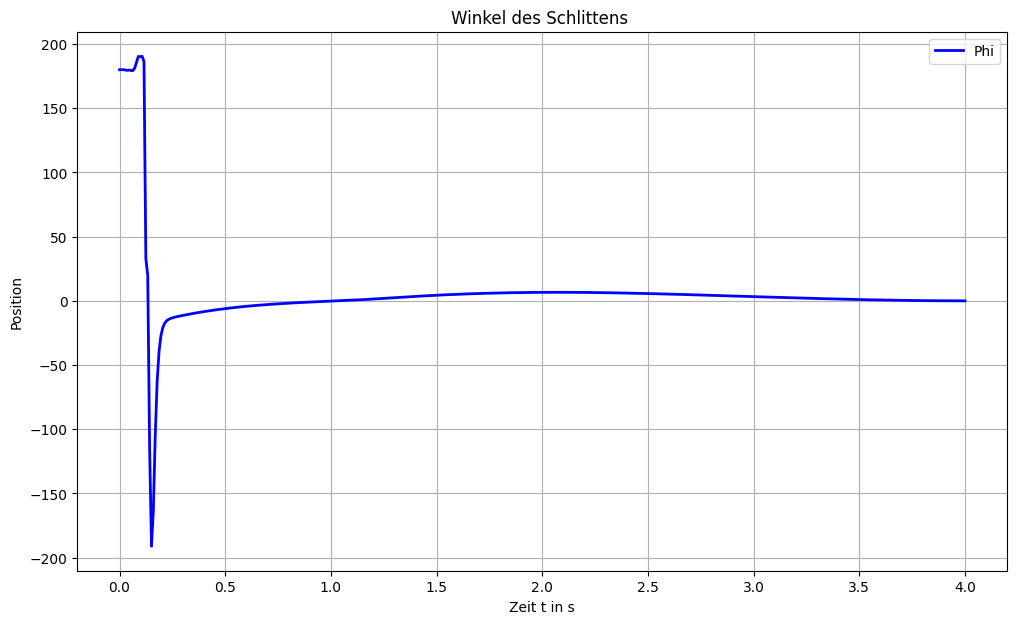

In [59]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Position')
plt.grid()
plt.plot(sol.x,sol.y[0]*180/np.pi,'b', linewidth ='2', label = 'Phi')
#plt.plot(sol.x,sol.y[1]*180/np.pi,'g', linewidth ='2', label = 'Omega')

plt.title('Winkel des Schlittens ')   
plt.legend(loc = 'best')
plt.show()

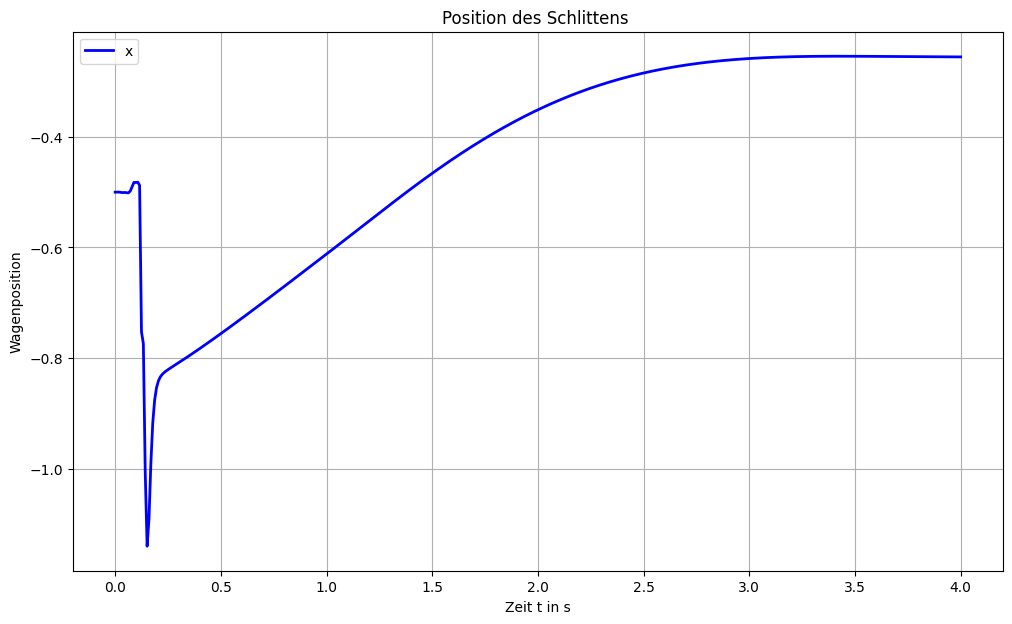

In [45]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Wagenposition')
plt.grid()
plt.plot(sol.x,sol.y[2],'b', linewidth ='2', label = 'x')
#plt.plot(sol.x,sol.y[3],'g', linewidth ='2', label = 'dx')

plt.title('Position des Schlittens ')   
plt.legend(loc = 'best')
plt.show()

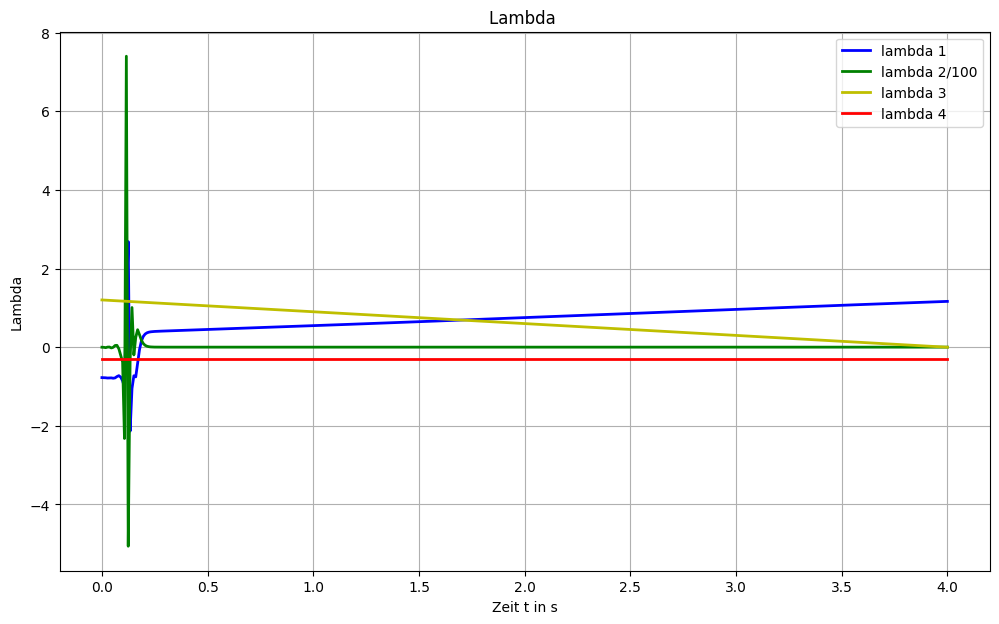

In [40]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Lambda')
plt.grid()
plt.plot(sol.x,sol.y[4],'b', linewidth ='2', label = 'lambda 1')
plt.plot(sol.x,sol.y[5]/100,'g', linewidth ='2', label = 'lambda 2/100')
plt.plot(sol.x,sol.y[6],'y', linewidth ='2', label = 'lambda 3')
plt.plot(sol.x,sol.y[7],'r', linewidth ='2', label = 'lambda 4')

plt.title('Lambda ')   
plt.legend(loc = 'best')
plt.show()

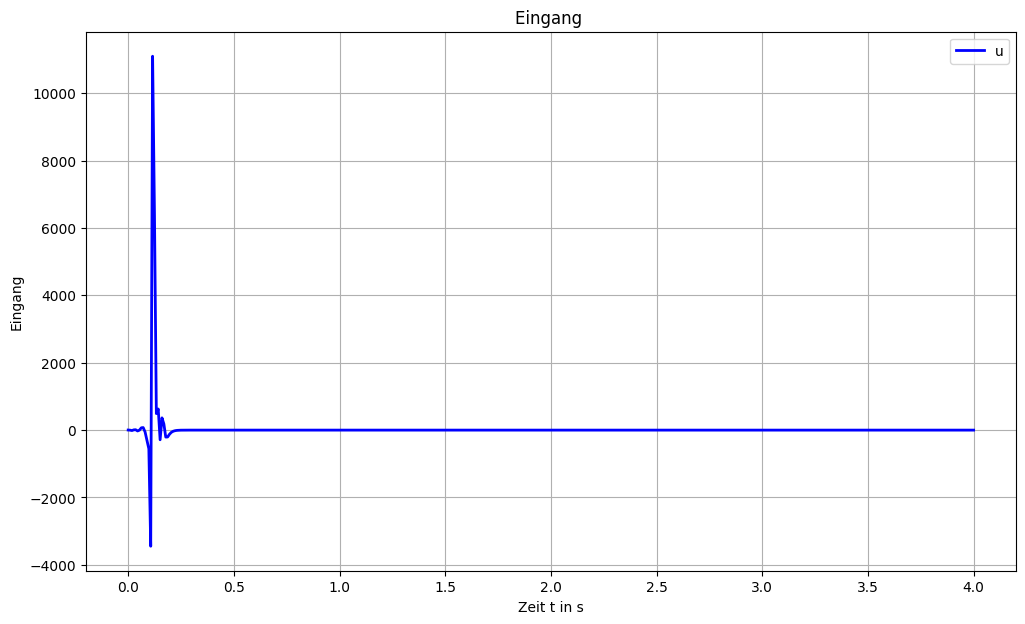

In [34]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Eingang')
plt.grid()
plt.plot(sol.x,U,'b', linewidth ='2', label = 'u')


plt.title('Eingang ')   
plt.legend(loc = 'best')
plt.show()

# Überprüfung

In [35]:
import control as ct
import control.optimal as obc


def system_update(t, x, u,params):
    # Return the derivative of the state
    return System_dynamic(x,u)

def system_output(t, x, u,params):
    return x

# Define the vehicle steering dynamics as an input/output system
Pendel = ct.NonlinearIOSystem(
    system_update, system_output, states=4, name='Pendel',
    inputs=('u'), outputs=('phi','omega','x','dx'))


input = U ;  timepts = sol.x


resp = ct.input_output_response(
    Pendel, timepts, input, x0,
    t_eval=t)
t_sim, y_sim, u_sim = resp.time, resp.outputs, resp.inputs


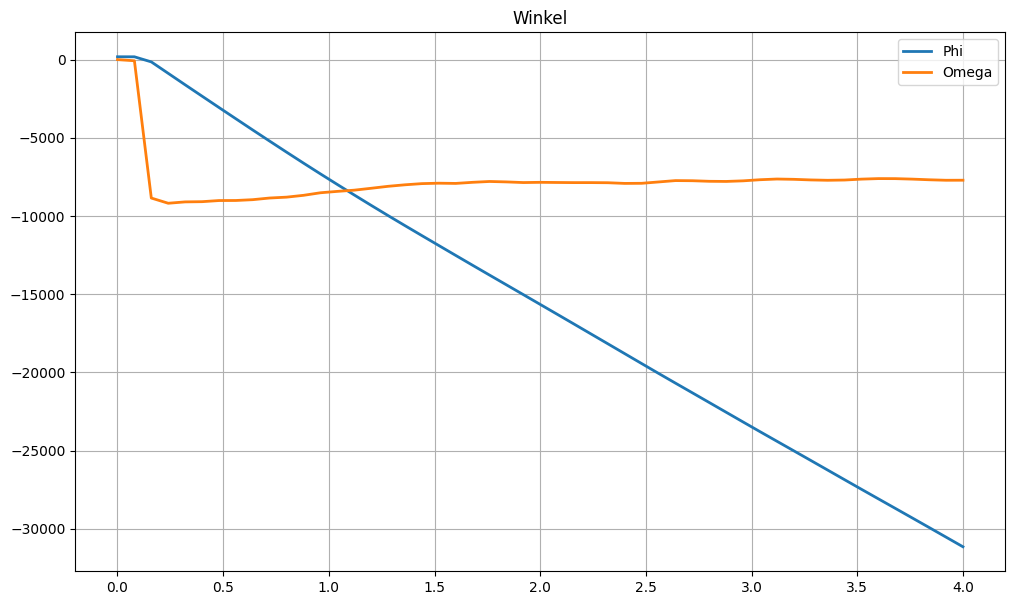

In [36]:
plt.figure(figsize=(12,7))
plt.figure(1)
#plt.plot(t_sim, y_sim[0])
plt.plot(t_sim, y_sim[0]*180/np.pi, linewidth ='2', label = 'Phi')
plt.plot(t_sim, y_sim[1]*180/np.pi, linewidth ='2', label = 'Omega')
plt.grid()
plt.title('Winkel')
plt.legend(loc = 'best')

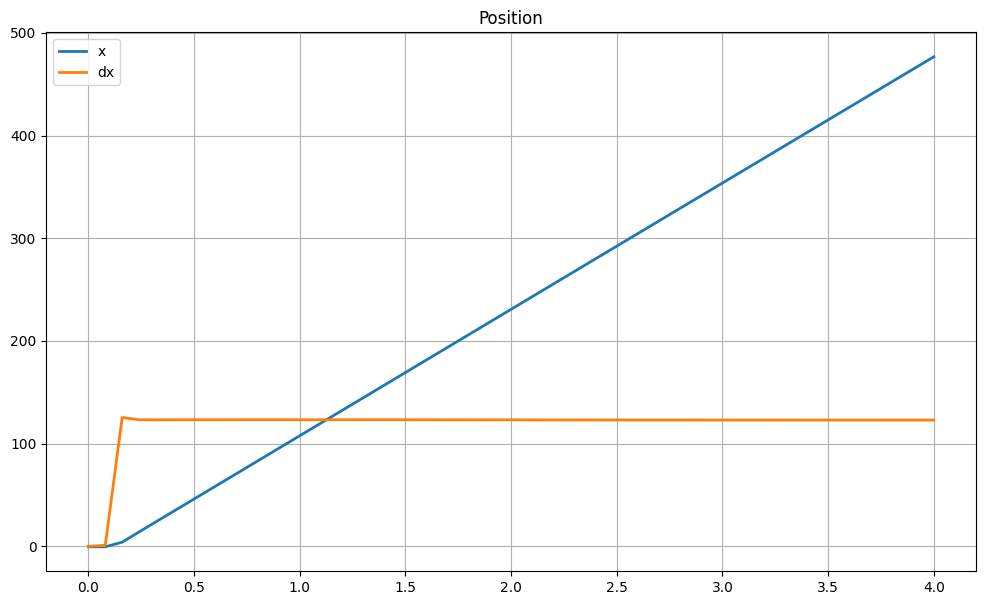

In [37]:
plt.figure(figsize=(12,7))
plt.figure(1)
plt.plot(t_sim, y_sim[2], linewidth ='2', label = 'x')
plt.plot(t_sim, y_sim[3], linewidth ='2', label = 'dx')
#plt.plot(t_sim, y_sim[2])
plt.grid()
plt.title('Position')
plt.legend(loc = 'best')

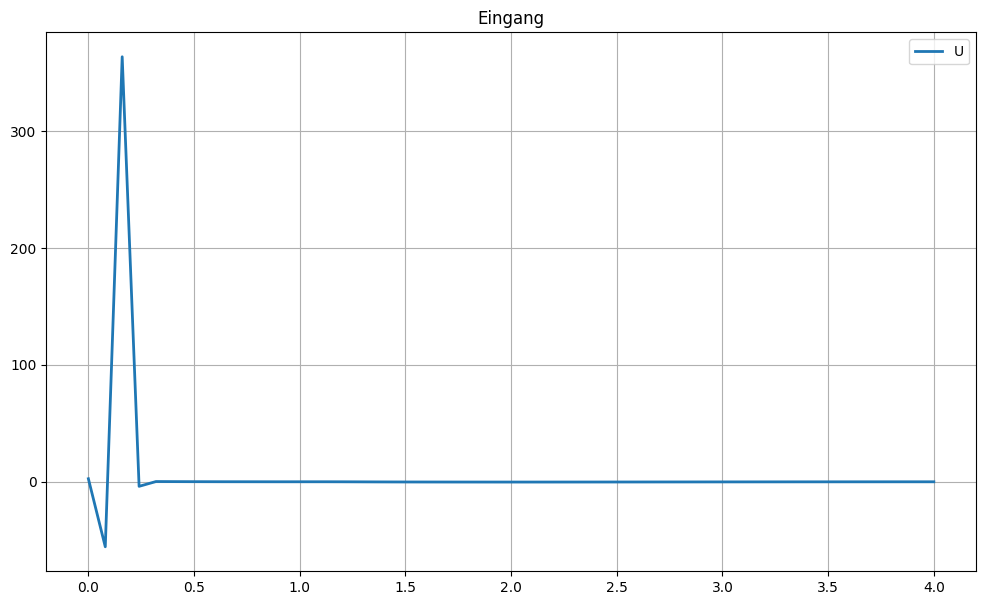

In [38]:
plt.figure(figsize=(12,7))
plt.figure(1)
plt.plot(t_sim, u_sim[0], linewidth ='2', label = 'U')
plt.grid()
plt.title('Eingang')
plt.legend(loc = 'best')